# **Data Cleaning**

## Objectives

* Evaluate missing data
* Clean data

## Inputs

* outputs/datasets/collection/mushrooms.csv

## Outputs

* Generate cleaned Train and Test sets, saved under outputs/datasets/cleaned
* Data Cleaning Pipeline

## Additional Comments

* Drop `veil-type` as it only has one distinct value and is therefore redundant.


---

# Change working directory

* Need to change working directory from the current jupyter_notebooks folder to the parent folder in order to access the whole project

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/mushroom-safety/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/mushroom-safety'

---

# Load collected data

In [4]:
import pandas as pd
df_raw_path = "outputs/datasets/collection/mushrooms.csv"
df = pd.read_csv(df_raw_path)
df.head()

,Unnamed: 0,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,0,x,s,n,t,p,f,c,n,...,s,w,w,p,w,o,p,k,s,u
1,1,1,x,s,y,t,a,f,c,b,...,s,w,w,p,w,o,p,n,n,g
2,2,1,b,s,w,t,l,f,c,b,...,s,w,w,p,w,o,p,n,n,m
3,3,0,x,y,w,t,p,f,c,n,...,s,w,w,p,w,o,p,k,s,u
4,4,1,x,s,g,f,n,f,w,b,...,s,w,w,p,w,o,e,n,a,g


# Data Exploration

Check which columns have missing data - there is no columns missing data. 

In [5]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

[]

In [6]:
from ydata_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

There are no variables with missing data


# Correlation and PPS analysis

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

### Calculate Correlations and Power Predictive Score

We drop certain redundant variables from DataFrame to avoid clutter

In [8]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df.drop(['Unnamed: 0'], axis=1))

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The 

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%    50%    75%    max
ppscore  506.0  0.135  0.189  0.0  0.0  0.031  0.223  0.936


Display on heatmaps



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



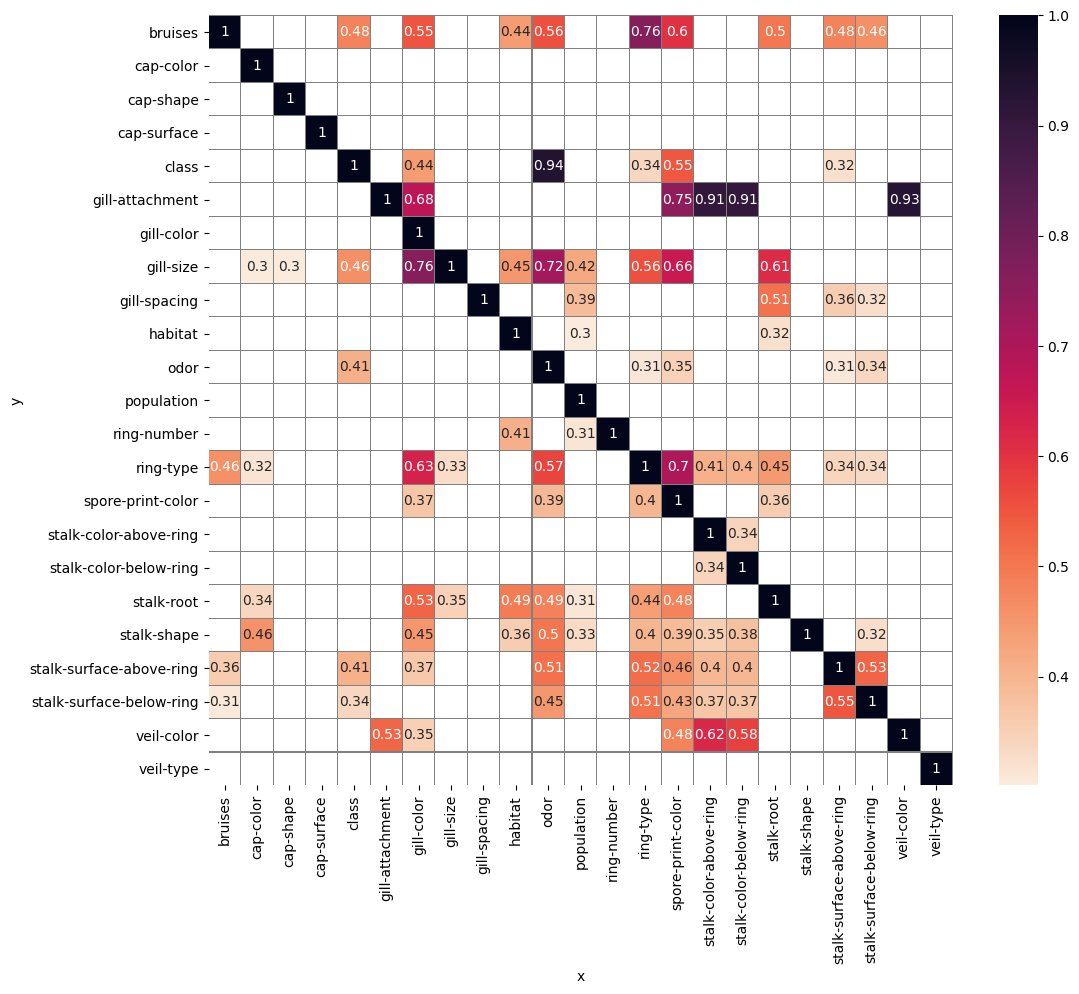

In [14]:
%matplotlib inline
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.01, PPS_Threshold =0.3,
                  figsize=(12,10), font_annot=10)

# Data Cleaning

As found previously, there is no explicitly missing data. However, from prior exploration of the dataset, we know there are customers with variables marked as `?`. These will need to be removed. Firstly, assess the levels of this in the dataset.

In [11]:
def EvaluateUnknownData(df):
    unknown_data_absolute = df.isin(['?']).sum()
    unknown_data_percentage = round(unknown_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithUnknownData": unknown_data_absolute,
                                   "PercentageOfDataset": unknown_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )
    
    return df_missing_data

Check unknown data for the dataset

In [12]:
EvaluateUnknownData(df)

,RowsWithUnknownData,PercentageOfDataset,DataType
stalk-root,2480,30.53,object


Imputation would be difficult to attempt here, as there is a lot of missing data. As the variable has a low correlation to the target, and the dataset is rich in other variables, we will drop this variable to have a dataset without missing values.

### Split Train and Test Set

In [16]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df_dropped,
                                        df_dropped['class'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

NameError: name 'df_dropped' is not defined

### Drop Variables

We will also drop variables previously identified as redundant. (However, including `Months_on_book` and `Avg_Utilization_Ratio` as we are interested in these variables as targets also). Also included in this is the variables that were previously dropped when the dataset was loaded in to avoid including them in the correlations and PPS score study. 

In [ ]:
variables_method = []

print(f"* {len(variables_method)} variables to drop \n\n"
    f"{variables_method}")

* 

Create separate DataFrame applying the imputation approach to selected variables.

In [ ]:
from feature_engine.selection import DropFeatures
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)
df_method = imputer.transform(TrainSet)

This has no effect on the datasets distribution, as it is just dropping columns

In [ ]:
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

---

# Push cleaned data to Repo

In [ ]:
import os
try:
    os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
    print(e)

### Train Set

In [ ]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

### Test Set

In [ ]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)